In [ ]:
#if youre running on colab, run this line first to properly load the h5 files
#pip install tables --upgrade

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import glob
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Homework 3
## Point Cloud MNIST with DeepSet


below you have a custom dataloader for the point-cloud MNIST dataset,

the training and validation datasets are linked from the course website

In [3]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        self.df = pd.read_hdf(path)
        
        self.label = torch.LongTensor(self.df.label)
        
        self.n_points = self.df.n_points
        
        
    def __len__(self):
       
        return len(self.label)


    def __getitem__(self, idx):
        
    
        return torch.FloatTensor(self.df.iloc[idx].xy), self.label[idx]

In [4]:
ds = CustomDataset('training_ds.h5')

#### the data is exactly like the MNIST dataset, except that instead of a 28x28 image,
#### you get a (N x 2) array of points (different number of points for each item in the dataset) 

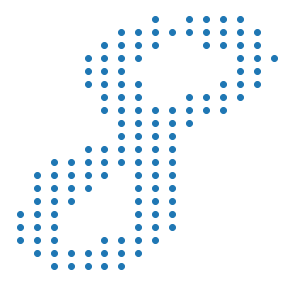

In [5]:
fig,ax = plt.subplots(figsize=(5,5))

xy = ds[445][0]

ax.scatter( xy[:,0],xy[:,1] )

ax.set_axis_off()

plt.show()

### the dataset object has a n_points variable that tells us how many points in each item

In [6]:
ds.n_points

0       117
1       130
2        88
3        70
4        97
       ... 
9995    120
9996    111
9997    114
9998     81
9999     88
Name: n_points, Length: 10000, dtype: object

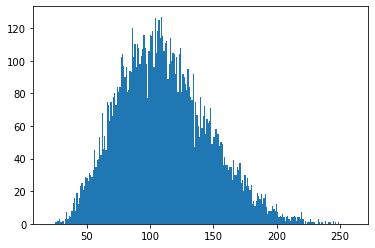

In [7]:
plt.hist(ds.n_points,np.linspace(19.5,260.5,242))
plt.show()

## One way to deal with this variable size is to use a custom Batch Sampler

https://pytorch.org/docs/stable/data.html

This object will tell our dataloader which item indices to request for the batches - 
and we can "rig" it to return batches where all the items have the same N, and therefore we can stack them without a custom colate function

In [11]:
class CustomBatchSampler(Sampler):
    def __init__(self, points_per_entry, batch_size):
        
        self.batch_size = batch_size
        self.N_per_entry = points_per_entry
        self.batches = {}
        
    def generate_batches(self):
        
        self.entries_with_N = {}
        running_idx = -1

        for N in set(self.N_per_entry):
            
            self.entries_with_N[N] = np.where(self.N_per_entry == N)[0]

            how_many = len(self.entries_with_N[N])
            n_batches = np.amax([ how_many / self.batch_size, 1])

            self.entries_with_N[N] = np.array_split(np.random.permutation(self.entries_with_N[N]),
                                                           n_batches)
            for batch in self.entries_with_N[N]:
                running_idx += 1
                self.batches[running_idx] = batch

        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        
        self.generate_batches()
        
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.batches[i]

In [23]:
batch_size = 50
batch_sampler = CustomBatchSampler(ds.n_points, batch_size)
data_loader = DataLoader(ds, batch_sampler=batch_sampler)

In [24]:
for epoch in range(3):
    for x,y in data_loader:
        print(x.shape)
    break

torch.Size([3, 227, 2])
torch.Size([39, 166, 2])
torch.Size([59, 102, 2])
torch.Size([1, 29, 2])
torch.Size([30, 53, 2])
torch.Size([2, 27, 2])
torch.Size([18, 188, 2])
torch.Size([21, 179, 2])
torch.Size([31, 52, 2])
torch.Size([81, 125, 2])
torch.Size([6, 193, 2])
torch.Size([53, 139, 2])
torch.Size([51, 121, 2])
torch.Size([36, 158, 2])
torch.Size([12, 189, 2])
torch.Size([4, 212, 2])
torch.Size([1, 226, 2])
torch.Size([11, 183, 2])
torch.Size([13, 39, 2])
torch.Size([55, 112, 2])
torch.Size([55, 90, 2])
torch.Size([52, 78, 2])
torch.Size([5, 36, 2])
torch.Size([49, 157, 2])
torch.Size([48, 155, 2])
torch.Size([40, 59, 2])
torch.Size([36, 161, 2])
torch.Size([30, 175, 2])
torch.Size([62, 107, 2])
torch.Size([52, 123, 2])
torch.Size([57, 108, 2])
torch.Size([59, 102, 2])
torch.Size([27, 173, 2])
torch.Size([54, 64, 2])
torch.Size([2, 245, 2])
torch.Size([57, 116, 2])
torch.Size([53, 111, 2])
torch.Size([51, 87, 2])
torch.Size([42, 61, 2])
torch.Size([96, 81, 2])
torch.Size([52, 123, 

## Building a DeepSet model

you only have three components - a fully connected network that creates the node embedding, a sum operation, and a classifier

In [19]:
# the linear layer operates on the last dimension:

linear_layer = nn.Linear(10,5)

linear_layer(  torch.rand((345,10)) ).shape, linear_layer(  torch.rand((345,76,10)) ).shape

(torch.Size([345, 5]), torch.Size([345, 76, 5]))

In [20]:
# for the the mean operation you need to specify the dimension:

x = torch.rand((42,15,10))

torch.mean(x,dim=1).shape

torch.Size([42, 10])

## build the model, train, submit when you reach above 75% accuracy on the validation set:

In [73]:
class DeepSet(nn.Module):
    def __init__(self):
        super(DeepSet, self).__init__()


    
    def forward(self, x):
        
       
        
        return ... 

In [74]:
net = DeepSet()

In [21]:
def compute_accuracy(data_loader,net):
    
    net.eval()
    
    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:
        
        prediction = net(x).data.numpy()
        
        prediction = np.argmax(prediction,axis=1)
        
        correct = len( np.where(prediction==y.data.numpy())[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
        
    return total_correct/float(total_number)

In [95]:
test_ds = CustomDataset('valid_ds.h5')
batch_size = 50
batch_sampler_test_ds = CustomBatchSampler(test_ds.n_points, batch_size)
data_loader_test = DataLoader(test_ds, batch_sampler=batch_sampler_test_ds)

compute_accuracy(data_loader_test,net)